This notebook sets up and runs a series of analyses that are dispatched either locally (using the `subprocess` Python module) or remotely onto a *Slurm*+*singularity* enabled computer cluster, to parallelize the computation.

The analysis consists in processing regions of interest from multiple (here two) SPT data files.
Each region of interest is spatially segmented, and then DV inference is performed in the resulting space bins.

Such computation can be easily parallelized for the various regions of interest.

# Approach

In this notebook, we will perform all these operations in a single step that will be distributed down to the region-of-interest level (or granularity).

[Another notebook](RWAnalyzer%20multi-stage%20pipeline.ipynb) demonstrates the pipeline capability dividing the segmentation and inference steps as distinct pipeline stages that are distributed down to distinct granularities.
As discussed in this other notebook, the multi-stage approach is more complex and raises a bunch of issues to be careful with.

As a consequence, we advise the user to favor the present notebook as a model to design custom "pipelines", in the cases the *'roi'* granularity is suitable for all the analysis steps that s·he wishes to parallelize.

# Launching the pipeline

If the notebook is run at least until the `a.run()` cell, the corresponding *.ipynb* file is exported and run in other processes or worker nodes.
This implies that the notebook should be saved (*Save and Checkpoint*, in the standard UI) before you *Restart & Run All*, if it has been recently modified.

The first notebook cells show how to set up the pipeline. The pipeline is actually launched at the `a.run()` cell of code, where `a` is the main `RWAnalyzer` object.

The notebook lines after the first call to the `run` method are never dispatched. Any second or third call to `run` would run the same initial part of the notebook. Calling `run` multiple times is consequently strongly discouraged.

# A simple *tessellate-and-infer* pipeline to resolve diffusivity and effective potential in space

The main difficulty in dispatching computations on remote hosts lies in locating the data files.
An approach that has been favored in the use cases developed as of version `0.5` consists of making all the paths absolute.

To match the local data files with a copy at a different location on the remote host, environment variables may be helpful.

Notably, the '\~' placeholder for the home/user directory is properly interpreted. If the local and remote data locations can be reached through a same path relative to the home directory, using this relative path made absolute with the '\~' placeholder should work fine without any explicit mapping.

As detailed by the [Locating the data](RWAnalyzer%20simple%20pipeline.ipynb#locating-the-data) section, data locations that differ on the local and remote hosts can be explicitly mapped on one another, with helpers for specific locations such as the *scratch* personal space.

Let us get the parent directory path of this notebook, assuming the TRamWAy source in locally available somewhere in the home directory:

In [1]:
import os

wd = '~/' + os.path.relpath(os.getcwd(), os.path.expanduser('~')).replace('\\', '/')
wd

'~/Projects/TRamWAy/notebooks'

We set up an `RWAnalyzer` object with SPT data files, the corresponding files for regions of interest,
the segmentation to be applied to each ROI, and the inference procedure to be applied to each microdomain.

In [2]:
from tramway.analyzer import *

a                                 = RWAnalyzer()

a.spt_data.from_ascii_files(f'{wd}/data-examples/*.rpt.txt')
a.spt_data.localization_precision = 0.03

a.roi.from_ascii_files(suffix='roi') # => *.rpt-roi.txt, for a total of 105 ROI

a.tesseller                       = tessellers.Hexagons
a.tesseller.resolution            = 0.05

a.sampler                         = sampler.Knn(10)

a.mapper                          = models.DV('stochastic')
a.mapper.diffusivity_prior        = 20
a.mapper.potential_prior          = 1
a.mapper.worker_count             = None if os.name == 'nt' else 5 # Windows OS is not fully supported yet
a.mapper.max_runtime              = 3 # in seconds; 3s is by far too short of a duration, and for testing only

**note for testing**: to check the notebook runs alright, it is reasonable to begin with fast and coarse segmentations of the spatial support of the data into nearest-neighbor-augmented bins and early-stopped inference, For example, `tessellers.Hexagons`, default resolution (undefined `RWAnalyzer.tesseller.resolution`), `sampler.Knn(10)` and `models.DV(variant='stochastic')` (NOT `models.DV(start='stochastic')`) with `RWAnalyzer.mapper.max_runtime = 3` make a good combination in this respect.
However, do not forget to revert these changes to *production* settings once the notebook seems ready.

Let us make sure the paths are alright. The following two notebook cells are optional.

Of note, this notebook assumes the [introduction notebook](RWAnalyzer%20tour.ipynb) ran before, so that the input data (both SPT and ROI files) are available.

In [3]:
a.spt_data.filepaths

['/home/flaurent/Projects/TRamWAy/notebooks/data-examples/Manip01-01-Beta400AA-01-15ms.rpt.txt',
 '/home/flaurent/Projects/TRamWAy/notebooks/data-examples/Manip01-01-Beta400AA-02-15ms.rpt.txt']

In [4]:
[ f.roi.filepath for f in a.spt_data ]

['/home/flaurent/Projects/TRamWAy/notebooks/data-examples/Manip01-01-Beta400AA-01-15ms.rpt-roi.txt',
 '/home/flaurent/Projects/TRamWAy/notebooks/data-examples/Manip01-01-Beta400AA-02-15ms.rpt-roi.txt']

Before defining the main pipeline stage, we can ensure that none of *.rwa* files to be generated exists, both on the submit and worker sides, introducing the following `fresh_start` stage:

In [5]:
def fresh_start(self):
    """
    Deletes the *.rwa* files associated with the SPT data files, if any.
    """
    for f in self.spt_data:
        output_rwa_file = os.path.splitext(f.source)[0] + '.rwa'
        try:
            os.unlink(output_rwa_file)
        except FileNotFoundError:
            pass
        else:
            f.logger.debug(f'file deleted: {output_rwa_file}')

a.pipeline.append_stage(fresh_start, run_everywhere=True)

In this example, the `fresh_start` stage makes no difference as long as the output *.rwa* files do not exist.

However, if the output *.rwa* files already exist, the pipeline loads and updates these files with the new analysis artefacts.
Worse: if the same analysis labels can be found in the *.rwa* files, the corresponding analyses are skipped unless argument `overwrite=True` is passed to `tessellate_and_infer`.

In addition, in the general case, if the `tessellate_and_infer` stage totally fails and the pipeline on the submit side does not get aware of the failure, the user may not realize the expected files have not been updated.

**note about `run_everywhere`**: in a local environment, this option has no effet. However, when multiple hosts are involved, with multiple copies of the data, unlike `tessellate_and_infer` that needs to (and should) run on the remote host only, stages like `fresh_start` should independently run on all the hosts; hence the option.

In [6]:
a.pipeline.append_stage(stages.tessellate_and_infer())

The declarative approach to setting a pipeline grants control over how to run the pipeline.

This allows running arrays of inferences equally on a local computer or across a computer cluster. The RWAnalyzer pipeline capability has been focused in particular on Slurm- and singularity-enabled clusters, communicating with these clusters through an SSH connection.

At *Institut Pasteur* in Paris, France, the main computer cluster was baptised *Maestro*.
The `environments` module exported by the `tramway.analyzer` package features a `Maestro` predefined environment that can be used to set the `env` attribute of an `RWAnalyzer` object.

This environment object takes the local username to connect to the *Maestro* submit node. This can be overriden with the `env.username` attribute.

However, the Maestro cluster is accessible only over *Institut Pasteur*'s VPN or from the campus.

To make this notebook run in more different circumstances, we will use the `LocalHost` environment instead.
This environment operates in a similar fashion, but on the local computer, and does not involve any remote resource.

It actually offers a convenient way to test a pipeline before running the same pipeline on a computer cluster.

In [7]:
#a.env                             = environments.Maestro # works only over Institut Pasteur's VPN or on campus
a.env                             = environments.LocalHost # replacement so that the demo can work anywhere
a.env.worker_count                = 4 # beware this multiplies with a.mapper.worker_count

a.env.script                      = 'RWAnalyzer simple pipeline.ipynb'

Of note, the `LocalHost` environment does not need absolute paths to the data files.

If someday you may export this notebook as a regular Python script, you should consider using the `__file__` variable, as demonstrated in the following code cell, as a replacement for the last line above. Otherwise, you can safely delete the following cell:

In [8]:
try:
    a.env.script                  = __file__
except NameError:
    # in an IPython notebook, `__file__` is not defined and there is no standard way to get the notebook's name
    a.env.script                  = 'RWAnalyzer simple pipeline.ipynb'

The following cell is also optional. The default logging (or verbosity) level is `INFO`.

In [9]:
import logging

a.logger.setLevel(logging.DEBUG)

The `run` method launches the pipeline.
The workload is concentrated in the following code cell:

In [10]:
a.run()

working directory: /tmp/tmpg0cmoy2j
setup complete
running: jupyter nbconvert --to python "/home/flaurent/Projects/TRamWAy/notebooks/RWAnalyzer simple pipeline.ipynb" --stdout
initial dispatch done

jobs ready
submitting: /usr/bin/python3 /tmp/tmpg0cmoy2j/tmppy560_ln.py --working-directory="/tmp/tmpg0cmoy2j" --stage-index=0
jobs submitted
setup complete
stage 0 ready
file deleted: /home/flaurent/Projects/TRamWAy/notebooks/data-examples/Manip01-01-Beta400AA-01-15ms.rpt.rwa
file deleted: /home/flaurent/Projects/TRamWAy/notebooks/data-examples/Manip01-01-Beta400AA-02-15ms.rpt.rwa
stage 0 done
job 0 done

jobs complete

jobs ready
submitting: /usr/bin/python3 /tmp/tmpg0cmoy2j/tmppy560_ln.py --working-directory="/tmp/tmpg0cmoy2j" --stage-index=1 --source="/home/flaurent/Projects/TRamWAy/notebooks/data-examples/Manip01-01-Beta400AA-01-15ms.rpt.txt" --region-index=0
submitting: /usr/bin/python3 /tmp/tmpg0cmoy2j/tmppy560_ln.py --working-directory="/tmp/tmpg0cmoy2j" --stage-index=1 --source="/h

setup complete
stage 1 ready
tessellating roi: 'roi012' (in source '/home/flaurent/Projects/TRamWAy/notebooks/data-examples/Manip01-01-Beta400AA-01-15ms.rpt.txt')...
inferring roi: 'roi012' (in source '/home/flaurent/Projects/TRamWAy/notebooks/data-examples/Manip01-01-Beta400AA-01-15ms.rpt.txt')...
stage 1 done
job 12 done

submitting: /usr/bin/python3 /tmp/tmpg0cmoy2j/tmppy560_ln.py --working-directory="/tmp/tmpg0cmoy2j" --stage-index=1 --source="/home/flaurent/Projects/TRamWAy/notebooks/data-examples/Manip01-01-Beta400AA-01-15ms.rpt.txt" --region-index=16
setup complete
stage 1 ready
tessellating roi: 'roi013' (in source '/home/flaurent/Projects/TRamWAy/notebooks/data-examples/Manip01-01-Beta400AA-01-15ms.rpt.txt')...
inferring roi: 'roi013' (in source '/home/flaurent/Projects/TRamWAy/notebooks/data-examples/Manip01-01-Beta400AA-01-15ms.rpt.txt')...
stage 1 done
job 13 done

submitting: /usr/bin/python3 /tmp/tmpg0cmoy2j/tmppy560_ln.py --working-directory="/tmp/tmpg0cmoy2j" --stage-in

job 26 done

submitting: /usr/bin/python3 /tmp/tmpg0cmoy2j/tmppy560_ln.py --working-directory="/tmp/tmpg0cmoy2j" --stage-index=1 --source="/home/flaurent/Projects/TRamWAy/notebooks/data-examples/Manip01-01-Beta400AA-02-15ms.rpt.txt" --region-index=8
setup complete
stage 1 ready
tessellating roi: 'roi005' (in source '/home/flaurent/Projects/TRamWAy/notebooks/data-examples/Manip01-01-Beta400AA-02-15ms.rpt.txt')...
inferring roi: 'roi005' (in source '/home/flaurent/Projects/TRamWAy/notebooks/data-examples/Manip01-01-Beta400AA-02-15ms.rpt.txt')...
stage 1 done
job 27 done

submitting: /usr/bin/python3 /tmp/tmpg0cmoy2j/tmppy560_ln.py --working-directory="/tmp/tmpg0cmoy2j" --stage-index=1 --source="/home/flaurent/Projects/TRamWAy/notebooks/data-examples/Manip01-01-Beta400AA-02-15ms.rpt.txt" --region-index=9
setup complete
stage 1 ready
tessellating roi: 'roi006' (in source '/home/flaurent/Projects/TRamWAy/notebooks/data-examples/Manip01-01-Beta400AA-02-15ms.rpt.txt')...
inferring roi: 'roi00

job 41 done

submitting: /usr/bin/python3 /tmp/tmpg0cmoy2j/tmppy560_ln.py --working-directory="/tmp/tmpg0cmoy2j" --stage-index=1 --source="/home/flaurent/Projects/TRamWAy/notebooks/data-examples/Manip01-01-Beta400AA-02-15ms.rpt.txt" --region-index=23
setup complete
stage 1 ready
tessellating roi: 'roi020' (in source '/home/flaurent/Projects/TRamWAy/notebooks/data-examples/Manip01-01-Beta400AA-02-15ms.rpt.txt')...
inferring roi: 'roi020' (in source '/home/flaurent/Projects/TRamWAy/notebooks/data-examples/Manip01-01-Beta400AA-02-15ms.rpt.txt')...
stage 1 done
job 42 done

submitting: /usr/bin/python3 /tmp/tmpg0cmoy2j/tmppy560_ln.py --working-directory="/tmp/tmpg0cmoy2j" --stage-index=1 --source="/home/flaurent/Projects/TRamWAy/notebooks/data-examples/Manip01-01-Beta400AA-02-15ms.rpt.txt" --region-index=24
setup complete
stage 1 ready
tessellating roi: 'roi021' (in source '/home/flaurent/Projects/TRamWAy/notebooks/data-examples/Manip01-01-Beta400AA-02-15ms.rpt.txt')...
inferring roi: 'roi

job 56 done

submitting: /usr/bin/python3 /tmp/tmpg0cmoy2j/tmppy560_ln.py --working-directory="/tmp/tmpg0cmoy2j" --stage-index=1 --source="/home/flaurent/Projects/TRamWAy/notebooks/data-examples/Manip01-01-Beta400AA-02-15ms.rpt.txt" --region-index=38
setup complete
stage 1 ready
tessellating roi: 'roi035' (in source '/home/flaurent/Projects/TRamWAy/notebooks/data-examples/Manip01-01-Beta400AA-02-15ms.rpt.txt')...
inferring roi: 'roi035' (in source '/home/flaurent/Projects/TRamWAy/notebooks/data-examples/Manip01-01-Beta400AA-02-15ms.rpt.txt')...
stage 1 done
job 57 done

submitting: /usr/bin/python3 /tmp/tmpg0cmoy2j/tmppy560_ln.py --working-directory="/tmp/tmpg0cmoy2j" --stage-index=1 --source="/home/flaurent/Projects/TRamWAy/notebooks/data-examples/Manip01-01-Beta400AA-02-15ms.rpt.txt" --region-index=39
setup complete
stage 1 ready
tessellating roi: 'roi036' (in source '/home/flaurent/Projects/TRamWAy/notebooks/data-examples/Manip01-01-Beta400AA-02-15ms.rpt.txt')...
inferring roi: 'roi

job 71 done

submitting: /usr/bin/python3 /tmp/tmpg0cmoy2j/tmppy560_ln.py --working-directory="/tmp/tmpg0cmoy2j" --stage-index=1 --source="/home/flaurent/Projects/TRamWAy/notebooks/data-examples/Manip01-01-Beta400AA-02-15ms.rpt.txt" --region-index=53
setup complete
stage 1 ready
tessellating roi: 'roi050' (in source '/home/flaurent/Projects/TRamWAy/notebooks/data-examples/Manip01-01-Beta400AA-02-15ms.rpt.txt')...
inferring roi: 'roi050' (in source '/home/flaurent/Projects/TRamWAy/notebooks/data-examples/Manip01-01-Beta400AA-02-15ms.rpt.txt')...
stage 1 done
job 72 done

submitting: /usr/bin/python3 /tmp/tmpg0cmoy2j/tmppy560_ln.py --working-directory="/tmp/tmpg0cmoy2j" --stage-index=1 --source="/home/flaurent/Projects/TRamWAy/notebooks/data-examples/Manip01-01-Beta400AA-02-15ms.rpt.txt" --region-index=54
setup complete
stage 1 ready
tessellating roi: 'roi051' (in source '/home/flaurent/Projects/TRamWAy/notebooks/data-examples/Manip01-01-Beta400AA-02-15ms.rpt.txt')...
inferring roi: 'roi

job 86 done

submitting: /usr/bin/python3 /tmp/tmpg0cmoy2j/tmppy560_ln.py --working-directory="/tmp/tmpg0cmoy2j" --stage-index=1 --source="/home/flaurent/Projects/TRamWAy/notebooks/data-examples/Manip01-01-Beta400AA-02-15ms.rpt.txt" --region-index=68
setup complete
stage 1 ready
tessellating roi: 'roi065' (in source '/home/flaurent/Projects/TRamWAy/notebooks/data-examples/Manip01-01-Beta400AA-02-15ms.rpt.txt')...
inferring roi: 'roi065' (in source '/home/flaurent/Projects/TRamWAy/notebooks/data-examples/Manip01-01-Beta400AA-02-15ms.rpt.txt')...
stage 1 done
job 87 done

submitting: /usr/bin/python3 /tmp/tmpg0cmoy2j/tmppy560_ln.py --working-directory="/tmp/tmpg0cmoy2j" --stage-index=1 --source="/home/flaurent/Projects/TRamWAy/notebooks/data-examples/Manip01-01-Beta400AA-02-15ms.rpt.txt" --region-index=69
setup complete
stage 1 ready
tessellating roi: 'roi066' (in source '/home/flaurent/Projects/TRamWAy/notebooks/data-examples/Manip01-01-Beta400AA-02-15ms.rpt.txt')...
inferring roi: 'roi

job 101 done

setup complete
stage 1 ready
tessellating roi: 'roi080' (in source '/home/flaurent/Projects/TRamWAy/notebooks/data-examples/Manip01-01-Beta400AA-02-15ms.rpt.txt')...
inferring roi: 'roi080' (in source '/home/flaurent/Projects/TRamWAy/notebooks/data-examples/Manip01-01-Beta400AA-02-15ms.rpt.txt')...
stage 1 done
job 102 done

setup complete
stage 1 ready
tessellating roi: 'roi081' (in source '/home/flaurent/Projects/TRamWAy/notebooks/data-examples/Manip01-01-Beta400AA-02-15ms.rpt.txt')...
inferring roi: 'roi081' (in source '/home/flaurent/Projects/TRamWAy/notebooks/data-examples/Manip01-01-Beta400AA-02-15ms.rpt.txt')...
stage 1 done
job 103 done

setup complete
stage 1 ready
tessellating roi: 'roi082' (in source '/home/flaurent/Projects/TRamWAy/notebooks/data-examples/Manip01-01-Beta400AA-02-15ms.rpt.txt')...
inferring roi: 'roi082' (in source '/home/flaurent/Projects/TRamWAy/notebooks/data-examples/Manip01-01-Beta400AA-02-15ms.rpt.txt')...
stage 1 done
job 104 done

jobs 

At this point, the pipeline execution is complete. As many *.rwa* files as input SPT data files were generated both on the local and remote hosts (if different).

With the default segmentation settings, the inference fails on several regions of interest.
This often occur when the sampling is too coarse or fine-grain, especially if no overlap is allowed between space bins.
However, this does not prevent the analyzer to process the other ROI and gather the available result files.

# Post-processing

To locally run further analyses on the generated parameter maps, it is first necessary to reload the retrieved *.rwa* files:

In [11]:
a.spt_data.reload_from_rwa_files();

Again, the above expression will run only in the local notebook kernel.

In other notebooks, the same step may be performed with the equivalent expression ``stages.reload(skip_missing=True)(a)``.

Note that if the pipeline was already run and the expected *.rwa* files are available, one can simply comment out the `a.run()` expression that triggers the execution of the registered stages. 

As a trivial post-processing example, let us show one of the generated maps:

In [12]:
for f in a.spt_data:
    
    for roi_index, _ in f.roi.as_individual_roi(return_index=True):
    
        # here, a single collection of roi was defined, and no label was associated
        support_region = f.roi.get_support_region(roi_index)

        # again, no label was supplied to identify the sampling approach
        sampling = support_region.get_sampling()

        # no label was supplied to identify the model either
        maps = sampling.get_child()

        break
    break

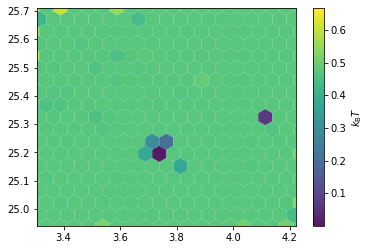

In [13]:
a.mapper.mpl.plot(maps, feature='potential', unit='std')

As can be noted, the inference for the initially-flat effective potential would definitely benefit from running more than 3 seconds.

# Locating the data

## Input data files are not dispatched

The above diagram calls for a long explanation but, first of all, the most important point here is that scripts and executables only are dispatched, and the **input data are NOT dispatched** onto the worker side.

This means that the user has to prepare the data on both the submit and worker sides.
This includes SPT data files and ROI files.

Unless set otherwise, the pipeline seeks the input data files at the same paths on both sides, which is not trivial.
The recommended approach consists of locating the data either from the filesystem root (/) or home/user directory.
The home/user directory path is automatically adjusted from a filesystem to the other.

## Designating side-dependent data locations

A standard setup consists of having the data stored in a (*e.g.* cookiecutter) directory structure, say at root directory *~/Projects/my-project*, on the computer that runs Jupyter, while on the cluster file system the *my-project* subdirectory is available in the personal scratch space.

If the personal scratch space can be found on the cluster reading an environment variable, say *$MYSCRATCH*, and this environment variable is not available on the local computer, one can set the working directory `wd` variable defined at the beginning of the notebook as:

In [14]:
import os

project_dir = '/'.join((os.environ.get('MYSCRATCH', '~/Projects'), 'my_project'))

wd = '/'.join((project_dir, 'data', 'processed')) # standard cookiecutter data location

In situations similar to the above one, with possibly distinct data locations on the submit and worker hosts,
it is also required to instruct the `env` attribute of the RWAnalyzer so that it can map the local *~/Projects* directory to the remote scratch location, using the `directory_mapping` dictionnary of the `env` attribute.

Keys are local paths (on the submit host), values are remote paths (on the worker host).

For scratch locations on the clusters described by some pre-defined environments (*e.g.* Maestro), the path can be programmatically retrieved with:

In [15]:
maestro_username = 'flaurent'

a = RWAnalyzer()

a.env = environments.Maestro

a.env.username = maestro_username # optional if same username on both the submit and worker hosts

a.env.directory_mapping['~/Projects'] = a.env.scratch(maestro_username)

# Designing pipeline stages

## Stage granularity and pipeline-ready iterators

A stage is registered in the RWAnalyzer object using the `pipeline.append_stage` method.
A simple `callable` (Python function) can be passed, like `fresh_start`.

Additional keyword arguments allow to define the granularity of the stage, *i.e.* the level of data representation suitable for distributing the data and running parallel instances of the same stage.

For example, with `granularity='ROI'`, a stage will apply in parallel to each region of interest independently, or more exactly to each *support region* independently.

With `granularity='SPT data'`, a stage will apply in parallel to each SPT data file.

Such control is made possible provided that the stage functions crawl the entire data using the following RWAnalyzer iterators:

* `spt_data` (the attribute itself is iterable),
* `spt_data.as_dataframes`,
* `spt_data.filter_by_source`,
* `roi.as_support_regions` (but **NOT** `roi.as_individual_roi`),
* `time.as_time_segments`.

The predefined stages exposed by the `stages` module are shipped as `PipelineStage` objects that readily contain default granularity settings. For example, the `tessellate_and_infer` stage is set for the ROI granularity, which falls back to SPT data files if no ROI are defined.

Of note, the `roi`-level iterators seamlessly run, independently of whether ROI are defined or not. If no ROI are defined, a `FullRegion` object is yielded for each SPT data file to represent the entire data while exposing the same attributes and methods as any `IndividualROI` or `SupportRegion` object.

See also the [time segment granularity](RWAnalyzer%20multi-stage%20pipeline.ipynb#Granularity-and-parallelism-for-time-segments).

## Editing the *tessellate_and_infer* stage

*tessellate\_and\_infer* (or more precisely *\_tessellate\_and\_infer* below) can be redefined as a standard function, that we generate here with the following simplified code:

In [16]:
def tessellate_and_infer(map_label=None, sampling_label=None):
    
    def _tessellate_and_infer(self):
        """
        Iterates the support regions, gets the mobile trajectories
        """
        for r in self.roi.as_support_regions():

            # get the data within the ROI as a dataframe
            translocations = r.crop()

            # keep only the molecules that move by more than the localization precision
            translocations = r.discard_static_trajectories(translocations)

            # tessellate, and run the time window if any
            sampling = self.sampler.sample(translocations)

            # infer the model parameters
            maps = self.mapper.infer(sampling)

            with r.autosaving():
                # wrap the original `sampling` and `maps` objects in node-like objects;
                # this stores the analysis artefacts in the analysis tree for ROI `r`
                sampling = commit_as_analysis(sampling_label, sampling, parent=r)
                maps     = commit_as_analysis(map_label, maps, parent=sampling)
    
    return _tessellate_and_infer

In [17]:
a.pipeline.append_stage(tessellate_and_infer(), granularity='roi')

The above code can serve as a simple basis for extending TRamWAy's standard pipeline.

The call to `autosaving` helps `RWAnalyzer` to track the files to be later retrieved onto the local host, in the case of multi-host execution.
Additional files can be individually designated as to be retrieved from the remote host with `a.pipeline.add_collectible(filepath)`.
This does not hurt local (`LocalHost`) or environment-free (undefined `env`) execution.

\[To be continued\]

See more about stage design in the [multi-stage pipeline notebook](RWAnalyzer%20multi-stage%20pipeline.ipynb), and especially about possible [optimizations for distributed computation](RWAnalyzer%20multi-stage%20pipeline.ipynb#Partial-interim-.rwa-files-for-large-data-files).

See also [tramway-tour.readthedocs.io/../scalability.html](https://tramway-tour.readthedocs.io/en/latest/scalability.html).

# Debugging

A stage is expected to log messages and a `logger` attribute is exposed for convenience by the `RWAnalyzer` object.

The `LocalHost` environment also has the advantage to reproduce the log messages in the output of the notebook cell. As for `SingularitySlurm` environments such as `Maestro`, because the number of tasks is expected to be large, the log output of each task is concealed in *.out*/*.err* files in the working directory on the remote host. The location of the working directory is reported by the `run` method.

Per default, the *.out* and *.err* files are deleted together with the working directory on completion of the last pipeline stage. To keep these files alive after completion, set `a.env.debug = True`. You will have to manually delete the working directory afterwards.

Another advice: with `SingularitySlurm` environments, the local log output can be saved in a file with the (second) following code snippet to be inserted after `a.env.script` is defined and before `a.run()` is called:

In [18]:
a.env.script = 'RWAnalyzer simple pipeline.ipynb' # define again, since `a` was overwritten in cell 15

In [19]:
a.pipeline.early_setup()

if a.env.submit_side:
    
    import logging
    
    logfile  = os.path.splitext(a.env.script)[0]+'.log'
    
    a.logger.addHandler(logging.FileHandler(logfile))

# Runtime control and recovery

Hitting the *Interrupt the kernel* button or selecting the *Interrupt* entry in the *Kernel* submenu acts similarly to hitting Ctrl+C in the standard Python interpreter.
Interrupting is to be distinguished from stopping.

For example, DV inferences that run locally (with no environment or with environment `LocalHost`) will stop and return the estimated parameters in their current state, similarly to interruption by a timeout.
In this situation, the kernel will keep on running.

However, with a `SingularitySlurm` environment, on interruption the remote tasks will be halted using *scancel* and no result will be returned, including from DV inferences. If the working directory is set to be deleted on completion (default), it is deleted.

Halting/stopping the kernel leads to a more consistent behavior. The local Python kernel is halted and the running computations are supposed to be lost.
In addition, the working directory is not deleted.

Actually, with `SingularitySlurm` environments, the running Slurm jobs also keep on running until completion.
The halted local kernel does not retrieve the interim *.rwa* files and other collectibles.
Together with a preserved working directory, this makes it possible to recover the product of the orphaned Slurm tasks.

This can be done replacing `a.run()` by `a.pipeline.resume()`.
The `resume` method requires the index of the halted pipeline stage, the location of the working directory and the Slurm job ID.
If no input arguments are given, `resume` will prompt for pasting the log output of the halted pipeline. Alternatively, the log output can be passed as argument `log` (use heredoc strings!)
`resume` can parse log output with log level `INFO` (default) or `DEBUG`.

As another alternative, especially if the log output is lost, one may pass the relevant information as input arguments:

* the stage index is usually easy to guess; *e.g.* here, to resume the `tessellate_and_infer` stage, if this stage comes first, its index is 0; if instead it comes after `fresh_start`, it is numbered 1;
* the location of the working directory (absolute path on the remote host) can be found browsing the file system of the remote host; the temporary working directory name begins with 'tmp.';
* the Slurm job ID can be found with command `squeue -u <myusername>`; if you are unsure what the ID is, you can alternatively wait until `squeue` returns the header line only (does not list any job or task); the job ID is no longer required once the Slurm job array is complete (if `resume` prompts for log output, hit Enter).

`resume` only resumes and completes the pipeline stage that was supposedly halted. The further stages are not run.

Note also that `resume` does not delete the working directory on the remote host.

See also [environments.SingularitySlurm.resume](https://tramway.readthedocs.io/en/latest/tramway.analyzer.html#tramway.analyzer.env.environments.SlurmOverSSH.resume).

# Shorter code sample

To make clear what notebook cells are critical in making the presented pipeline run with minimal setup, the definition code is summed up below.
A major difference in the following code samples is in the inference that is no longer early-stopped.

Note that `.run()` should not be called twice in a same Python script or notebook.

In [20]:
import os
from tramway.analyzer import *

a                                 = RWAnalyzer()

a.spt_data                        = spt_data.SPTAsciiFiles('data-examples/*.rpt.txt') # relative paths work alright with LocalHost
a.spt_data.localization_precision = 0.03

a.roi.from_ascii_files(suffix='roi') # => *.rpt-roi.txt

a.tesseller                       = tessellers.Hexagons
a.tesseller.resolution            = 0.05

a.sampler                         = sampler.Knn(10)

a.mapper                          = models.DV(start='stochastic')
a.mapper.diffusivity_prior        = 20
a.mapper.potential_prior          = 1
a.mapper.worker_count             = None if os.name == 'nt' else 5 # Windows OS is not fully supported yet

a.pipeline.append_stage(stages.tessellate_and_infer(overwrite=True))

a.env                             = environments.LocalHost
a.env.worker_count                = 4

# this code sample cannot run in the current notebook anyway;
# create a new notebook in the same directory, copy-paste this code cell,
# adjust the filename below so that it points at the new notebook,
# and uncomment the a.run() expression
a.env.script                      = 'Untitled.ipynb'

# a.run()

Of note, relative paths are properly interpreted by the `LocalHost` environment.

Similarly, for dispatching to Maestro:

In [21]:
from tramway.analyzer import *

a                                 = RWAnalyzer()

a.spt_data                        = spt_data.SPTAsciiFiles('data-examples/*.rpt.txt') # relative paths on the remote host are interpreted as relative to the home directory
a.spt_data.localization_precision = 0.03

a.roi.from_ascii_files(suffix='roi') # => *.rpt-roi.txt

a.tesseller                       = tessellers.Hexagons
a.tesseller.resolution            = 0.05

a.sampler                         = sampler.Knn(10)

a.mapper                          = models.DV(start='stochastic')
a.mapper.diffusivity_prior        = 20
a.mapper.potential_prior          = 1
a.mapper.worker_count             = 5

a.pipeline.append_stage(stages.tessellate_and_infer(overwrite=True),
        sbatch_options=dict(c=a.mapper.worker_count)) # translated as: -c 4

a.env                             = environments.Maestro
a.env.worker_count                = 40

# this code sample cannot run in the current notebook anyway;
# create a new notebook in the same directory, copy-paste this code cell,
# adjust the filename below so that it points at the new notebook,
# and uncomment the a.run() expression
a.env.script                      = 'Untitled1.ipynb'

## data preparation ##
a.pipeline.early_setup() # this logs in and sets `submit_side` and `worker_side` in the `env` attribute
if a.env.submit_side:
    # transfer local file tutorial.py into the remote home directory
    a.env.ssh.put('tutorial.py')
    # remotely run the raw data download procedure
    out, err = a.env.exec_inline_python('from tutorial import *; download_RWAnalyzer_tour_data()')
    # transfer the local files that are not shipped together with the raw data
    for f in a.spt_data:
        roi_file = f.roi.filepath
        a.env.ssh.put(roi_file)
######################

# a.run()

?---------   1 0        0               0 (unknown date) ?
introspection script transferred to: /pasteur/sonic/scratch/users/flaurent/tmp9m8gopxj.sh
running command: bash -l -c "module load singularity; chmod +x /pasteur/sonic/scratch/users/flaurent/tmp9m8gopxj.sh; singularity exec -H $HOME -B /pasteur tramway-hpc-210815-py38.sif /pasteur/sonic/scratch/users/flaurent/tmp9m8gopxj.sh; rm -f /pasteur/sonic/scratch/users/flaurent/tmp9m8gopxj.sh"

in container tramway-hpc-210815-py38.sif: selecting python command: 'python3.8'
running command: bash -l -c "module load singularity; singularity exec -H $HOME -B /pasteur tramway-hpc-210815-py38.sif python3.8 -s -c \"from tutorial import *; download_RWAnalyzer_tour_data()\""


In principle, the initial data transfer (`## data preparation ##` code block) is not part of such a pipeline script/notebook, as it has to be done only once for all, whereas the script may be run multiple times on the same data.

In this example, to make the notebook run from scratch, the dispatch of the data is included and performed the easiest way, sending the files straight into the home directory.

Indeed, as commented in the code, relative paths are interpreted as relative to the home directory on the remote host. The lack of consistency from an environment to another in the interpretation of relative paths makes it preferable to explicitly locate the data, either making the data available at the same location on all the hosts (possibly using links to directories), or checking out environment variables to define host-dependent absolute paths.

Another difference with the `LocalHost`-based script is that options are passed to *sbatch* to reserve the required resource on the worker nodes. Specifically, the *stochastic.dv* is set to use 4 processes (`a.mapper.worker_count`) and is the only processing step in the chain that takes profit from local multiprocessing. *sbatch* may perform better if informed about that.